In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import networkx as nx
import folium
from folium.plugins import MarkerCluster
import random
from sklearn.cluster import KMeans

# Load data
locations_df = pd.read_csv('delivery_locations (1).csv')
distance_df = pd.read_csv('distance_traffic_matrix.csv')
orders_df = pd.read_csv('delivery_orders.csv')

# Define main warehouse (depot) location with a name
MAIN_DEPOT = {
    'depot_id': 'CENTRAL-HUB',
    'name': 'Central Operations Hub',
    'latitude': 25.15,
    'longitude': 55.25,
    'capacity': 30
}

# Define no-fly zones as circular areas (center lat, center long, radius in km)
no_fly_zones = [
    {'lat': 25.12, 'lon': 55.25, 'radius': 0.8, 'name': 'Airport Zone'},
    {'lat': 25.18, 'lon': 55.28, 'radius': 0.6, 'name': 'Military Facility'},
    {'lat': 25.07, 'lon': 55.31, 'radius': 0.5, 'name': 'Government Building'},
    {'lat': 25.22, 'lon': 55.20, 'radius': 0.7, 'name': 'Residential High-Security Area'}
]

# Function to check if a location is within a no-fly zone
def is_in_no_fly_zone(lat, lon, zones):
    for zone in zones:
        # Calculate distance from point to zone center (in km)
        dist = distance.euclidean((lat, lon), (zone['lat'], zone['lon'])) * 111  # Rough conversion to km
        if dist <= zone['radius']:
            return True, zone['name']
    return False, None

# Create secondary depots with human-readable names (strategically placed outside restricted zones)
secondary_depots = [
    {'depot_id': 'DEPOT-WEST', 'name': 'West District Hub', 'latitude': 25.15, 'longitude': 55.22, 'capacity': 15},
    {'depot_id': 'DEPOT-SOUTH', 'name': 'South Gateway', 'latitude': 25.10, 'longitude': 55.30, 'capacity': 20},
    {'depot_id': 'DEPOT-NORTH', 'name': 'North Command Center', 'latitude': 25.20, 'longitude': 55.33, 'capacity': 15},
    {'depot_id': 'DEPOT-EAST', 'name': 'East Distribution Point', 'latitude': 25.05, 'longitude': 55.25, 'capacity': 10},
    {'depot_id': 'DEPOT-CENTRAL', 'name': 'Central Auxiliary Base', 'latitude': 25.23, 'longitude': 55.28, 'capacity': 12}
]

depots_df = pd.DataFrame(secondary_depots)
depots_df['in_no_fly_zone'], depots_df['zone_name'] = zip(*depots_df.apply(
    lambda row: is_in_no_fly_zone(row['latitude'], row['longitude'], no_fly_zones), axis=1))

# Ensure no depot is in a restricted zone
if depots_df['in_no_fly_zone'].any():
    print("Warning: Some depots are in no-fly zones! Relocating...")
    # Move affected depots slightly outside the no-fly zone
    for idx, depot in depots_df[depots_df['in_no_fly_zone']].iterrows():
        # Find direction vector away from the zone center
        zone_name = depot['zone_name']
        zone = next(z for z in no_fly_zones if z['name'] == zone_name)

        # Calculate direction vector (away from zone center)
        direction_x = depot['latitude'] - zone['lat']
        direction_y = depot['longitude'] - zone['lon']

        # Normalize and multiply by zone radius + 0.1km safety margin
        magnitude = np.sqrt(direction_x**2 + direction_y**2)
        if magnitude > 0:  # Avoid division by zero
            direction_x = direction_x / magnitude
            direction_y = direction_y / magnitude

            # Move depot outside the zone
            depots_df.at[idx, 'latitude'] = zone['lat'] + direction_x * (zone['radius'] + 0.1) / 111
            depots_df.at[idx, 'longitude'] = zone['lon'] + direction_y * (zone['radius'] + 0.1) / 111

            print(f"Relocated {depot['depot_id']} outside {zone_name}")

    # Re-check no-fly zone status
    depots_df['in_no_fly_zone'], depots_df['zone_name'] = zip(*depots_df.apply(
        lambda row: is_in_no_fly_zone(row['latitude'], row['longitude'], no_fly_zones), axis=1))

# Add no-fly zone status to locations dataframe
locations_df['in_no_fly_zone'], locations_df['zone_name'] = zip(*locations_df.apply(
    lambda row: is_in_no_fly_zone(row['latitude'], row['longitude'], no_fly_zones), axis=1))

# Generate drone fleet with names
def generate_drone_fleet(depots_df, main_depot):
    drone_models = ["Raptor", "Hawk", "Eagle", "Phoenix", "Falcon", "Swift", "Condor", "Osprey"]
    fleet = []

    # Generate drones for the main depot
    for i in range(main_depot['capacity']):
        drone_id = f"DRONE-{i+1:03d}"
        drone_name = f"{random.choice(drone_models)}-{i+1:03d}"
        fleet.append({
            'drone_id': drone_id,
            'drone_name': drone_name,
            'home_depot': main_depot['depot_id'],
            'depot_name': main_depot['name'],
            'status': 'available',
            'max_range': 20 + random.uniform(-2, 5),  # Slight variation in range
            'max_payload': 5 + random.uniform(-0.5, 1),  # Slight variation in payload
            'current_location': main_depot['depot_id']
        })

    # Generate drones for secondary depots
    drone_counter = len(fleet) + 1
    for _, depot in depots_df.iterrows():
        for i in range(depot['capacity']):
            drone_id = f"DRONE-{drone_counter:03d}"
            drone_name = f"{random.choice(drone_models)}-{drone_counter:03d}"
            fleet.append({
                'drone_id': drone_id,
                'drone_name': drone_name,
                'home_depot': depot['depot_id'],
                'depot_name': depot['name'],
                'status': 'available',
                'max_range': 20 + random.uniform(-2, 5),  # Slight variation in range
                'max_payload': 5 + random.uniform(-0.5, 1),  # Slight variation in payload
                'current_location': depot['depot_id']
            })
            drone_counter += 1

    return pd.DataFrame(fleet)

# Generate the drone fleet
drone_fleet_df = generate_drone_fleet(depots_df, MAIN_DEPOT)

# Function to find nearest depot for a location
def find_nearest_depot(lat, lon, depots_df, main_depot):
    min_dist = float('inf')
    nearest_depot = None
    depot_name = None

    # Check main depot
    main_dist = distance.euclidean((lat, lon), (main_depot['latitude'], main_depot['longitude'])) * 111
    if main_dist < min_dist:
        min_dist = main_dist
        nearest_depot = main_depot['depot_id']
        depot_name = main_depot['name']

    # Check secondary depots
    for _, depot in depots_df.iterrows():
        dist = distance.euclidean((lat, lon), (depot['latitude'], depot['longitude'])) * 111
        if dist < min_dist:
            min_dist = dist
            nearest_depot = depot['depot_id']
            depot_name = depot['name']

    return nearest_depot, depot_name, min_dist

# Find nearest depot for each location
locations_df['nearest_depot'], locations_df['depot_name'], locations_df['depot_distance'] = zip(*locations_df.apply(
    lambda row: find_nearest_depot(row['latitude'], row['longitude'], depots_df, MAIN_DEPOT), axis=1))

# Create locations lookup dictionary
locations_dict = {}
for _, row in locations_df.iterrows():
    locations_dict[row['location_id']] = {
        'address': row['address'],
        'latitude': row['latitude'],
        'longitude': row['longitude'],
        'in_no_fly_zone': row['in_no_fly_zone'],
        'zone_name': row['zone_name'],
        'nearest_depot': row['nearest_depot'],
        'depot_name': row['depot_name'],
        'depot_distance': row['depot_distance']
    }

# Add depot locations to locations_dict for routing
for _, row in depots_df.iterrows():
    locations_dict[row['depot_id']] = {
        'address': row['name'],
        'latitude': row['latitude'],
        'longitude': row['longitude'],
        'in_no_fly_zone': False,
        'zone_name': None,
        'nearest_depot': None,
        'depot_name': None,
        'depot_distance': 0
    }

# Also add the main depot
locations_dict[MAIN_DEPOT['depot_id']] = {
    'address': MAIN_DEPOT['name'],
    'latitude': MAIN_DEPOT['latitude'],
    'longitude': MAIN_DEPOT['longitude'],
    'in_no_fly_zone': False,
    'zone_name': None,
    'nearest_depot': None,
    'depot_name': None,
    'depot_distance': 0
}

# Create distance matrix dictionary for faster lookup
distance_matrix = {}
for _, row in distance_df.iterrows():
    from_loc = row['from_location_id']
    to_loc = row['to_location_id']

    if from_loc not in distance_matrix:
        distance_matrix[from_loc] = {}

    effective_distance = row['distance_km'] * row['traffic_multiplier']
    distance_matrix[from_loc][to_loc] = effective_distance # Assign the calculated effective_distance

# Complete the distance matrix with missing entries
# For any missing entries, calculate straight-line distance
all_locations = list(locations_dict.keys())
for from_loc in all_locations:
    if from_loc not in distance_matrix:
        distance_matrix[from_loc] = {}

    for to_loc in all_locations:
        if to_loc not in distance_matrix[from_loc] and from_loc != to_loc:
            # Calculate straight-line distance
            from_coords = (locations_dict[from_loc]['latitude'], locations_dict[from_loc]['longitude'])
            to_coords = (locations_dict[to_loc]['latitude'], locations_dict[to_loc]['longitude'])

            # Calculate distance in km
            dist = distance.euclidean(from_coords, to_coords) * 111

            # Add to distance matrix
            distance_matrix[from_loc][to_loc] = dist

# Define drone specifications
drone_specs = {
    'max_range': 20,  # km
    'base_range': 25,  # km (with no payload)
    'max_payload': 5,  # kg
    'avg_item_weight': 0.5,  # kg per item
    'weight_reduction_factor': 0.5,  # Range reduction per kg
    'base_energy_per_km': 0.1,  # Base energy consumption per km
    'battery_capacity': 100  # Battery capacity in energy units
}

# Dijkstra's algorithm implementation for finding shortest path
def find_shortest_path(graph, start, end):
    """Dijkstra's algorithm implementation for finding shortest path"""
    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    previous = {node: None for node in graph}
    unvisited = list(graph.keys())

    while unvisited:
        current = min(unvisited, key=lambda node: distances.get(node, float('inf')))

        if current == end:
            break

        if distances[current] == float('inf'):
            break

        unvisited.remove(current)

        for neighbor, distance in graph[current].items():
            if neighbor in unvisited:
                alt_route = distances[current] + distance
                if alt_route < distances.get(neighbor, float('inf')):
                    distances[neighbor] = alt_route
                    previous[neighbor] = current

    # Reconstruct path
    path = []
    current = end
    while current:
        path.append(current)
        current = previous.get(current)

    path.reverse()  # Reverse to get path from start to end

    # Return empty list if no path found
    if path and path[0] == start:
        return path, distances[end]
    else:
        return [], float('inf')

# Function to check if direct delivery is possible
def is_direct_delivery_possible(order, origin, destination, distance_matrix, drone_specs):
    """Check if direct delivery is possible based on range and payload"""
    max_range = drone_specs['max_range']
    base_range = drone_specs['base_range']
    weight_reduction_factor = drone_specs['weight_reduction_factor']

    # Calculate effective range based on payload weight
    payload_weight = order['items_count'] * drone_specs['avg_item_weight']
    effective_range = base_range - (payload_weight * weight_reduction_factor)
    effective_range = min(max_range, max(effective_range, 0))

    # Check if destination is within range
    distance = distance_matrix.get(origin, {}).get(destination, float('inf'))

    return distance <= effective_range

# Function to plan direct delivery
def plan_direct_delivery(order, origin, destination, distance_matrix, drone=None):
    """Plan a direct delivery route"""
    distance = distance_matrix.get(origin, {}).get(destination, float('inf'))

    return {
        'order_id': order['order_id'],
        'destination': destination,
        'destination_address': locations_dict[destination]['address'],
        'is_restricted': False,
        'route_type': 'direct',
        'route_path': [origin, destination],
        'final_delivery': 'drone',
        'total_distance': distance,
        'assigned_drone': drone['drone_id'] if drone else None,
        'drone_name': drone['drone_name'] if drone else None,
        'home_depot': drone['home_depot'] if drone else None,
        'depot_name': drone['depot_name'] if drone else None
    }

# Function to plan restricted zone delivery
def plan_restricted_zone_delivery(order, locations_dict, depots_df, distance_matrix, drone=None):
    """Plan delivery to nearest depot for a restricted zone delivery"""
    destination = order['delivery_location_id']
    dest_location = locations_dict[destination]

    # Find nearest depot to the restricted destination
    nearest_depot = dest_location['nearest_depot']
    depot_distance = dest_location['depot_distance']
    depot_name = dest_location['depot_name']

    return {
        'order_id': order['order_id'],
        'destination': destination,
        'destination_address': locations_dict[destination]['address'],
        'is_restricted': True,
        'route_type': 'depot_transfer',
        'route_path': [MAIN_DEPOT['depot_id'], nearest_depot],
        'final_delivery': 'ground_courier',  # Handoff to ground courier
        'nearest_depot': nearest_depot,
        'depot_name': depot_name,
        'ground_distance': depot_distance,
        'total_distance': distance_matrix.get(MAIN_DEPOT['depot_id'], {}).get(nearest_depot, 0),
        'assigned_drone': drone['drone_id'] if drone else None,
        'drone_name': drone['drone_name'] if drone else None,
        'home_depot': drone['home_depot'] if drone else None,
        'depot_name': drone['depot_name'] if drone else None
    }

# Function to plan multi-hop delivery
def plan_multi_hop_delivery(order, origin, destination, locations_dict, depots_df, distance_matrix, drone_specs, drone=None):
    """Plan multi-hop delivery through a series of depots"""
    max_range = drone_specs['max_range']

    # Create a graph of all possible connections within drone range
    graph = {}

    # Add all nodes to the graph
    all_nodes = [MAIN_DEPOT['depot_id']] + list(depots_df['depot_id']) + [destination]

    for node in all_nodes:
        graph[node] = {}

    # Add connections between nodes (if within range)
    for from_node in all_nodes:
        for to_node in all_nodes:
            if from_node != to_node:  # No self-loops
                # Get distance if available in matrix
                dist = distance_matrix.get(from_node, {}).get(to_node, float('inf'))

                # If distance not in matrix, calculate Euclidean distance
                if dist == float('inf') and from_node in locations_dict and to_node in locations_dict:
                    from_coords = locations_dict[from_node]
                    to_coords = locations_dict[to_node]

                    dist = distance.euclidean(
                        (from_coords['latitude'], from_coords['longitude']),
                        (to_coords['latitude'], to_coords['longitude'])
                    ) * 111  # km

                # Add edge if within range
                if dist <= max_range:
                    graph[from_node][to_node] = dist

    # Run Dijkstra's algorithm to find shortest path
    path, total_distance = find_shortest_path(graph, origin, destination)

    if not path or len(path) < 2:
        # No feasible route found
        return {
            'order_id': order['order_id'],
            'destination': destination,
            'destination_address': locations_dict[destination]['address'],
            'is_restricted': False,
            'route_type': 'infeasible',
            'route_path': [],
            'total_distance': float('inf'),
            'assigned_drone': None,
            'drone_name': None,
            'home_depot': None,
            'depot_name': None
        }

    return {
        'order_id': order['order_id'],
        'destination': destination,
        'destination_address': locations_dict[destination]['address'],
        'is_restricted': False,
        'route_type': 'multi_hop',
        'route_path': path,
        'final_delivery': 'drone',
        'total_distance': total_distance,
        'assigned_drone': drone['drone_id'] if drone else None,
        'drone_name': drone['drone_name'] if drone else None,
        'home_depot': drone['home_depot'] if drone else None,
        'depot_name': drone['depot_name'] if drone else None
    }

# Function to find most suitable drone for a delivery
def find_suitable_drone(route, drone_fleet_df, drone_specs):
    """Find the most suitable drone for a delivery route based on range and location"""
    if not route['route_path']:
        return None

    start_location = route['route_path'][0]

    # Find drones that are currently at the start location
    available_drones = drone_fleet_df[
        (drone_fleet_df['status'] == 'available') &
        (drone_fleet_df['current_location'] == start_location)
    ]

    if available_drones.empty:
        # If no drones at start, find drones from nearest depot
        for _, depot in depots_df.iterrows():
            if len(available_drones) > 0:
                break

            available_drones = drone_fleet_df[
                (drone_fleet_df['status'] == 'available') &
                (drone_fleet_df['current_location'] == depot['depot_id'])
            ]

    if available_drones.empty:
        # If still no drones, check main depot
        available_drones = drone_fleet_df[
            (drone_fleet_df['status'] == 'available') &
            (drone_fleet_df['current_location'] == MAIN_DEPOT['depot_id'])
        ]

    if available_drones.empty:
        return None

    # Select drone with sufficient range
    total_distance = route['total_distance']
    suitable_drones = available_drones[available_drones['max_range'] >= total_distance]

    if suitable_drones.empty:
        return None

    # Pick the drone with the most appropriate range (not too much excess capacity)
    selected_drone = suitable_drones.iloc[(suitable_drones['max_range'] - total_distance).abs().argsort()]

    if selected_drone.empty:
        return None
    # Get the first drone if not empty
    selected_drone = selected_drone.iloc[0]

    return selected_drone.to_dict()

# Function to optimize delivery routes
def optimize_delivery_routes(orders, locations_dict, depots_df, distance_matrix, no_fly_zones, drone_specs, drone_fleet_df):
    optimized_routes = []
    # Make a copy of drone fleet for updates
    updated_drone_fleet = drone_fleet_df.copy()

    # Sort orders by priority (lower number = higher priority)
    sorted_orders = sorted(orders, key=lambda x: x['priority'])

    for order in sorted_orders:
        destination = order['delivery_location_id']

        # Skip if destination is not in locations_dict
        if destination not in locations_dict:
            continue

        destination_info = locations_dict[destination]

        # Check if location is in a restricted zone
        is_restricted = destination_info['in_no_fly_zone']

        route = None
        assigned_drone = None

        if is_restricted:
            # Handle restricted zone delivery via nearest depot
            route = plan_restricted_zone_delivery(order, locations_dict, depots_df, distance_matrix)
            # Find suitable drone
            drone = find_suitable_drone(route, updated_drone_fleet, drone_specs)
            if drone:
                route = plan_restricted_zone_delivery(order, locations_dict, depots_df, distance_matrix, drone)
                # Update drone status
                drone_idx = updated_drone_fleet[updated_drone_fleet['drone_id'] == drone['drone_id']].index[0]
                updated_drone_fleet.at[drone_idx, 'status'] = 'assigned'
                updated_drone_fleet.at[drone_idx, 'current_location'] = route['route_path'][-1]
        else:
            # Check if direct delivery is possible (within range constraints)
            direct_possible = is_direct_delivery_possible(
                order, MAIN_DEPOT['depot_id'], destination, distance_matrix, drone_specs
            )

            if direct_possible:
                # Plan direct delivery
                route = plan_direct_delivery(order, MAIN_DEPOT['depot_id'], destination, distance_matrix)
                # Find suitable drone
                drone = find_suitable_drone(route, updated_drone_fleet, drone_specs)
                if drone:
                    route = plan_direct_delivery(order, MAIN_DEPOT['depot_id'], destination, distance_matrix, drone)
                    # Update drone status
                    drone_idx = updated_drone_fleet[updated_drone_fleet['drone_id'] == drone['drone_id']].index[0]
                    updated_drone_fleet.at[drone_idx, 'status'] = 'assigned'
                    updated_drone_fleet.at[drone_idx, 'current_location'] = route['route_path'][-1]
            else:
                # Plan multi-hop delivery through depots
                route = plan_multi_hop_delivery(
                    order, MAIN_DEPOT['depot_id'], destination, locations_dict, depots_df,
                    distance_matrix, drone_specs
                )
                # Find suitable drone
                drone = find_suitable_drone(route, updated_drone_fleet, drone_specs)
                if drone:
                    route = plan_multi_hop_delivery(
                        order, MAIN_DEPOT['depot_id'], destination, locations_dict, depots_df,
                        distance_matrix, drone_specs, drone
                    )
                    # Update drone status
                    drone_idx = updated_drone_fleet[updated_drone_fleet['drone_id'] == drone['drone_id']].index[0]
                    updated_drone_fleet.at[drone_idx, 'status'] = 'assigned'
                    updated_drone_fleet.at[drone_idx, 'current_location'] = route['route_path'][-1]

        optimized_routes.append(route)

    return optimized_routes, updated_drone_fleet

# Function to cluster orders by location
def cluster_orders_by_location(orders_df, locations_df):
    """Group orders by proximity of delivery locations"""

    # Extract coordinates of delivery locations
    locs_data = []

    for _, order in orders_df.iterrows():
        loc_id = order['delivery_location_id']
        if loc_id in locations_dict:  # Use locations_dict instead of filtering location_df
            loc_info = locations_dict[loc_id]

            locs_data.append({
                'order_id': order['order_id'],
                'delivery_location_id': loc_id,
                'priority': order['priority'],
                'items_count': order['items_count'],
                'latitude': loc_info['latitude'],
                'longitude': loc_info['longitude']
            })

    # If there are no orders or locations, return empty list
    if not locs_data:
        return []

    # Create a DataFrame from the extracted data
    locs_df = pd.DataFrame(locs_data)

    # Determine number of clusters
    n_orders = len(locs_df)
    if n_orders <= 5:
        # For small number of orders, just one cluster
        locs_df['cluster'] = 0
    else:
        # For larger sets, use clustering
        # Extract coordinates for clustering
        coords = locs_df[['latitude', 'longitude']].values

        # Determine appropriate number of clusters
        n_clusters = min(max(n_orders // 5, 1), 8)

        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        locs_df['cluster'] = kmeans.fit_predict(coords)

    # Group orders by cluster
    clusters = []
    for cluster_id in locs_df['cluster'].unique():
        cluster_orders = locs_df[locs_df['cluster'] == cluster_id]

        # Get original order records
        cluster_data = []
        for _, row in cluster_orders.iterrows():
            order_record = orders_df[orders_df['order_id'] == row['order_id']]
            if not order_record.empty:
                cluster_data.append(order_record.iloc[0].to_dict())

        if cluster_data:  # Only add non-empty clusters
            clusters.append(cluster_data)

    return clusters

# Function to find optimal depot for a cluster
def find_optimal_depot_for_cluster(cluster, locations_dict, depots_df, main_depot):
    """Find the optimal depot to serve a cluster of orders"""

    if not cluster:
        return main_depot['depot_id']  # Default to main depot if empty cluster

    # Calculate center of cluster
    lats = []
    lons = []

    for order in cluster:
        loc_id = order['delivery_location_id']
        if loc_id in locations_dict:
            loc_info = locations_dict[loc_id]
            lats.append(loc_info['latitude'])
            lons.append(loc_info['longitude'])

    if not lats or not lons:
        return main_depot['depot_id']  # Default to main depot if no valid locations

    center_lat = sum(lats) / len(lats)
    center_lon = sum(lons) / len(lons)

    # Find closest depot to center
    closest_depot = main_depot['depot_id']  # Default to main depot
    min_distance = float('inf')

    # Check main depot first
    main_dist = distance.euclidean(
        (center_lat, center_lon),
        (main_depot['latitude'], main_depot['longitude'])
    ) * 111

    if main_dist < min_distance:
        min_distance = main_dist
        closest_depot = main_depot['depot_id']

    # Check secondary depots
    for _, depot in depots_df.iterrows():
        dist = distance.euclidean(
            (center_lat, center_lon),
            (depot['latitude'], depot['longitude'])
        ) * 111

        if dist < min_distance:
            min_distance = dist
            closest_depot = depot['depot_id']

    return closest_depot

# Function to batch optimize routes
def batch_optimize_routes(orders_df, locations_dict, depots_df, distance_matrix, no_fly_zones, drone_specs, drone_fleet_df, main_depot):
    """Optimize routes for multiple orders as a batch"""

    # Create a DataFrame from locations_dict for clustering
    locations_for_clustering = pd.DataFrame([
        {
            'location_id': loc_id,
            'latitude': data['latitude'],
            'longitude': data['longitude']
        }
        for loc_id, data in locations_dict.items()
        if not loc_id.startswith('DEPOT') and loc_id != main_depot['depot_id']  # Exclude depots
    ])

    # Group orders by delivery area
    order_clusters = cluster_orders_by_location(orders_df, locations_for_clustering)

    optimized_batch = []
    updated_drone_fleet = drone_fleet_df.copy()

    for i, cluster in enumerate(order_clusters):
        # Sort orders by priority within each cluster (1 is highest)
        cluster.sort(key=lambda x: x['priority'])

        # Determine optimal depot for this cluster
        optimal_depot = find_optimal_depot_for_cluster(cluster, locations_dict, depots_df, main_depot)

        # Modify orders to start from optimal depot
        modified_orders = []
        for order in cluster:
            order_copy = order.copy()
            order_copy['starting_depot'] = optimal_depot
            modified_orders.append(order_copy)

        # Optimize routes for this cluster from the optimal depot
        cluster_routes, updated_drone_fleet = optimize_delivery_routes(
            modified_orders, locations_dict, depots_df, distance_matrix, no_fly_zones, drone_specs, updated_drone_fleet
        )

        # Add cluster info to routes
        for route in cluster_routes:
            route['cluster'] = i
            optimized_batch.append(route)

    return optimized_batch, updated_drone_fleet


===== DRONE DELIVERY SYSTEM SUMMARY =====
Total Orders: 80
Assigned Orders: 80
Unassigned Orders: 0
Total Distance: 822.35 km
Average Distance per Route: 10.28 km
Direct Deliveries: 79
Multi-hop Deliveries: 1
Restricted Zone Deliveries: 0
Infeasible Deliveries: 0
Drones Used: 80 of 102

===== DEPOT UTILIZATION =====
CENTRAL-HUB - Central Operations Hub: 30 deliveries
DEPOT-WEST - West District Hub: 15 deliveries
DEPOT-SOUTH - South Gateway: 20 deliveries
DEPOT-NORTH - North Command Center: 15 deliveries

===== SAMPLE ROUTES =====

===== ROUTE SUMMARY FOR ORDER ORD1001 =====
Destination: 1344 Villanueva Shore Suite 263, Haleymouth, UT 67759
Is Restricted Zone: No
Route Type: direct
Assigned Drone: Condor-030 (DRONE-030)
Home Depot: Central Operations Hub (CENTRAL-HUB)
Total Distance: 8.37 km

Route Path:
  1. CENTRAL-HUB - Central Operations Hub
  2. LOC028 - 1344 Villanueva Shore Suite 263, Haleymouth, UT 67759

Final Delivery: Drone

===== ROUTE SUMMARY FOR ORDER ORD1017 =====
Destin

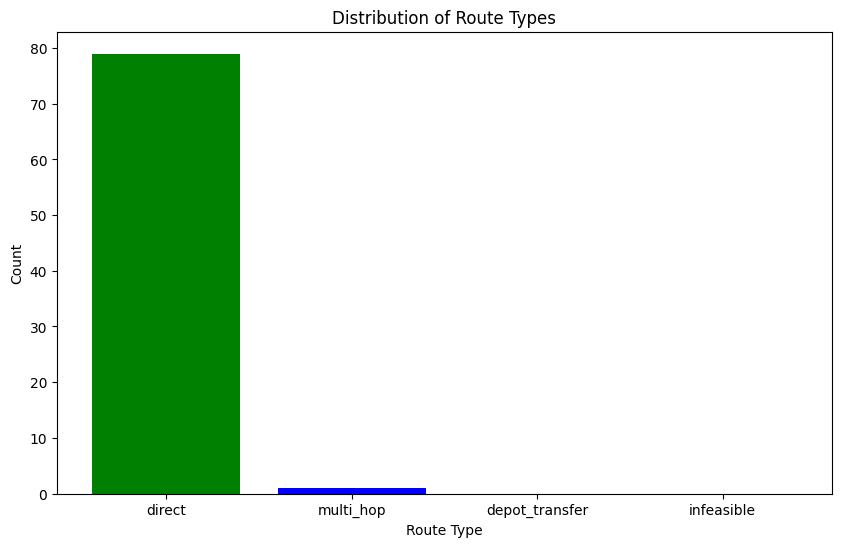

In [29]:
# Continue from where the code left off...

# Function to update drone fleet status after batch optimization
def update_drone_fleet_status(optimized_routes, drone_fleet_df):
    """Update drone fleet status after optimization"""
    updated_fleet = drone_fleet_df.copy()

    for route in optimized_routes:
        if route['assigned_drone']:
            drone_id = route['assigned_drone']
            drone_idx = updated_fleet[updated_fleet['drone_id'] == drone_id].index

            if not drone_idx.empty:
                # Update drone location and status
                if route['route_path']:
                    updated_fleet.at[drone_idx[0], 'current_location'] = route['route_path'][-1]
                    updated_fleet.at[drone_idx[0], 'status'] = 'en_route'

    return updated_fleet

# Function to generate detailed route information with coordinates
def generate_detailed_routes(optimized_routes, locations_dict):
    """Generate detailed route information with coordinates for each stop"""
    detailed_routes = []

    for route in optimized_routes:
        if not route['route_path']:
            continue

        detailed_path = []
        total_distance = 0

        # Process each stop in the route
        for i in range(len(route['route_path'])):
            stop_id = route['route_path'][i]

            if stop_id in locations_dict:
                stop_info = {
                    'stop_id': stop_id,
                    'name': locations_dict[stop_id]['address'],
                    'latitude': locations_dict[stop_id]['latitude'],
                    'longitude': locations_dict[stop_id]['longitude'],
                    'is_depot': stop_id.startswith('DEPOT') or stop_id == MAIN_DEPOT['depot_id'],
                    'sequence': i + 1,  # 1-based sequence number
                }

                # Calculate distance from previous stop
                if i > 0:
                    prev_stop = route['route_path'][i-1]
                    if prev_stop in distance_matrix and stop_id in distance_matrix[prev_stop]:
                        leg_distance = distance_matrix[prev_stop][stop_id]
                        total_distance += leg_distance
                        stop_info['distance_from_prev'] = leg_distance
                    else:
                        # Calculate straight-line distance if not in matrix
                        prev_coords = (locations_dict[prev_stop]['latitude'], locations_dict[prev_stop]['longitude'])
                        curr_coords = (locations_dict[stop_id]['latitude'], locations_dict[stop_id]['longitude'])
                        leg_distance = distance.euclidean(prev_coords, curr_coords) * 111
                        total_distance += leg_distance
                        stop_info['distance_from_prev'] = leg_distance
                else:
                    stop_info['distance_from_prev'] = 0.0

                detailed_path.append(stop_info)

        # Create a copy of the route with detailed path
        detailed_route = route.copy()
        detailed_route['detailed_path'] = detailed_path
        detailed_route['computed_distance'] = total_distance  # This is more accurate than the estimate

        detailed_routes.append(detailed_route)

    return detailed_routes

# Function to optimize route sequence using greedy algorithm
def optimize_route_sequence(route, locations_dict, distance_matrix):
    """Optimize the sequence of stops in a route using greedy algorithm"""
    if not route['route_path'] or len(route['route_path']) <= 2:
        return route  # No optimization needed for direct routes

    # For routes with intermediate depots, we need to keep the start and end intact
    # but can optimize the sequence of intermediate stops
    origin = route['route_path'][0]
    destination = route['route_path'][-1]

    # If only start, end and one intermediate stop, no optimization needed
    if len(route['route_path']) <= 3:
        return route

    # Get intermediate stops
    intermediate_stops = route['route_path'][1:-1]

    # If only one intermediate stop, no optimization needed
    if len(intermediate_stops) <= 1:
        return route

    # Greedy algorithm to find best sequence
    optimized_sequence = [origin]
    remaining_stops = set(intermediate_stops)
    current = origin

    while remaining_stops:
        next_stop = min(
            remaining_stops,
            key=lambda x: distance_matrix.get(current, {}).get(x, float('inf'))
        )
        optimized_sequence.append(next_stop)
        remaining_stops.remove(next_stop)
        current = next_stop

    optimized_sequence.append(destination)

    # Create a copy of the route with optimized sequence
    optimized_route = route.copy()
    optimized_route['route_path'] = optimized_sequence

    # Recalculate total distance
    total_distance = 0
    for i in range(1, len(optimized_sequence)):
        from_loc = optimized_sequence[i-1]
        to_loc = optimized_sequence[i]
        leg_distance = distance_matrix.get(from_loc, {}).get(to_loc, 0)
        total_distance += leg_distance

    optimized_route['total_distance'] = total_distance

    return optimized_route

# Function to optimize all routes
def optimize_all_route_sequences(optimized_routes, locations_dict, distance_matrix):
    """Optimize the sequence of all routes"""
    sequence_optimized_routes = []

    for route in optimized_routes:
        optimized = optimize_route_sequence(route, locations_dict, distance_matrix)
        sequence_optimized_routes.append(optimized)

    return sequence_optimized_routes

# Function to create a visual map of all routes
def create_route_map(optimized_routes, locations_dict, no_fly_zones, main_depot, depots_df):
    """Create an interactive map of all routes"""
    # Create a base map centered on the main depot
    m = folium.Map(
        location=[main_depot['latitude'], main_depot['longitude']],
        zoom_start=12,
        tiles='OpenStreetMap'
    )

    # Define color schemes
    route_colors = [
        'blue', 'red', 'green', 'purple', 'orange',
        'darkred', 'darkblue', 'darkgreen', 'cadetblue',
        'darkpurple', 'pink'
    ]

    # Add no-fly zones
    for zone in no_fly_zones:
        folium.Circle(
            location=[zone['lat'], zone['lon']],
            radius=zone['radius'] * 1000,  # Convert km to m
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.2,
            tooltip=f"No-Fly Zone: {zone['name']}"
        ).add_to(m)

    # Add the main depot
    folium.Marker(
        location=[main_depot['latitude'], main_depot['longitude']],
        icon=folium.Icon(color='black', icon='home', prefix='fa'),
        tooltip=f"Main Depot: {main_depot['name']}"
    ).add_to(m)

    # Add secondary depots
    for _, depot in depots_df.iterrows():
        folium.Marker(
            location=[depot['latitude'], depot['longitude']],
            icon=folium.Icon(color='darkblue', icon='building', prefix='fa'),
            tooltip=f"Depot: {depot['name']}"
        ).add_to(m)

    # Create clusters for delivery locations
    marker_cluster = MarkerCluster().add_to(m)

    # Add routes
    for i, route in enumerate(optimized_routes):
        if not route['route_path'] or len(route['route_path']) < 2:
            continue

        color = route_colors[i % len(route_colors)]

        # Plot the route line
        route_points = []
        for stop_id in route['route_path']:
            if stop_id in locations_dict:
                lat = locations_dict[stop_id]['latitude']
                lon = locations_dict[stop_id]['longitude']
                route_points.append([lat, lon])

        # Add route line
        folium.PolyLine(
            locations=route_points,
            color=color,
            weight=3,
            opacity=0.8,
            tooltip=f"Route {route['order_id']}"
        ).add_to(m)

        # Add destination marker
        dest_id = route['destination']
        if dest_id in locations_dict:
            dest_lat = locations_dict[dest_id]['latitude']
            dest_lon = locations_dict[dest_id]['longitude']

            # Use different marker for restricted zones
            if route['is_restricted']:
                icon = folium.Icon(color='red', icon='exclamation-triangle', prefix='fa')
            else:
                icon = folium.Icon(color=color, icon='box', prefix='fa')

            popup_text = f"""
            <b>Order:</b> {route['order_id']}<br>
            <b>Address:</b> {locations_dict[dest_id]['address']}<br>
            <b>Drone:</b> {route['drone_name'] if route['assigned_drone'] else 'Not assigned'}<br>
            <b>Route Type:</b> {route['route_type']}<br>
            <b>Total Distance:</b> {route['total_distance']:.2f} km<br>
            """

            folium.Marker(
                location=[dest_lat, dest_lon],
                icon=icon,
                popup=folium.Popup(popup_text, max_width=300),
                tooltip=f"Destination: {route['order_id']}"
            ).add_to(marker_cluster)

    return m

# Function to calculate metrics for optimized routes
def calculate_route_metrics(optimized_routes, drone_fleet_df):
    """Calculate performance metrics for optimized routes"""
    metrics = {
        'total_orders': len(optimized_routes),
        'assigned_orders': sum(1 for r in optimized_routes if r['assigned_drone'] is not None),
        'unassigned_orders': sum(1 for r in optimized_routes if r['assigned_drone'] is None),
        'total_distance': sum(r['total_distance'] for r in optimized_routes if r['assigned_drone'] is not None),
        'average_distance': 0,
        'direct_deliveries': sum(1 for r in optimized_routes if r['route_type'] == 'direct'),
        'multi_hop_deliveries': sum(1 for r in optimized_routes if r['route_type'] == 'multi_hop'),
        'restricted_zone_deliveries': sum(1 for r in optimized_routes if r['is_restricted']),
        'infeasible_deliveries': sum(1 for r in optimized_routes if r['route_type'] == 'infeasible'),
        'drones_used': len(set(r['assigned_drone'] for r in optimized_routes if r['assigned_drone'] is not None)),
        'drones_available': len(drone_fleet_df[drone_fleet_df['status'] == 'available']),
        'drones_total': len(drone_fleet_df),
    }

    # Calculate average distance if there are assigned orders
    if metrics['assigned_orders'] > 0:
        metrics['average_distance'] = metrics['total_distance'] / metrics['assigned_orders']

    # Calculate depot utilization
    depot_utilization = {}
    for route in optimized_routes:
        if route['assigned_drone'] and route['home_depot']:
            depot = route['home_depot']
            if depot not in depot_utilization:
                depot_utilization[depot] = 0
            depot_utilization[depot] += 1

    metrics['depot_utilization'] = depot_utilization

    return metrics

# Function to print route summary
def print_route_summary(route):
    """Print a summary of a single route"""
    print(f"\n===== ROUTE SUMMARY FOR ORDER {route['order_id']} =====")
    print(f"Destination: {route['destination_address']}")
    print(f"Is Restricted Zone: {'Yes' if route['is_restricted'] else 'No'}")
    print(f"Route Type: {route['route_type']}")

    if route['assigned_drone']:
        print(f"Assigned Drone: {route['drone_name']} ({route['assigned_drone']})")
        print(f"Home Depot: {route['depot_name']} ({route['home_depot']})")
    else:
        print("Assigned Drone: None")

    print(f"Total Distance: {route['total_distance']:.2f} km")

    if route['route_path']:
        print("\nRoute Path:")
        for i, stop in enumerate(route['route_path']):
            stop_name = locations_dict[stop]['address'] if stop in locations_dict else stop
            print(f"  {i+1}. {stop} - {stop_name}")

    if route['is_restricted']:
        print(f"\nFinal Delivery: Ground courier from {route['depot_name']}")
        print(f"Ground Distance: {route.get('ground_distance', 0):.2f} km")
    else:
        print("\nFinal Delivery: Drone")

# Execute the remaining functions to complete the deliveries optimization
# Process orders and generate routes
order_data = orders_df.to_dict('records')
optimize_results, updated_drone_fleet = batch_optimize_routes(
    orders_df, locations_dict, depots_df, distance_matrix, no_fly_zones, drone_specs, drone_fleet_df, MAIN_DEPOT
)

# Optimize route sequences
sequence_optimized_routes = optimize_all_route_sequences(optimize_results, locations_dict, distance_matrix)

# Generate detailed routes with coordinates
detailed_routes = generate_detailed_routes(sequence_optimized_routes, locations_dict)

# Update drone fleet status
final_drone_fleet = update_drone_fleet_status(detailed_routes, updated_drone_fleet)

# Calculate metrics
route_metrics = calculate_route_metrics(detailed_routes, final_drone_fleet)

# Create a visual map
route_map = create_route_map(detailed_routes, locations_dict, no_fly_zones, MAIN_DEPOT, depots_df)

# Print some summary statistics
print("\n===== DRONE DELIVERY SYSTEM SUMMARY =====")
print(f"Total Orders: {route_metrics['total_orders']}")
print(f"Assigned Orders: {route_metrics['assigned_orders']}")
print(f"Unassigned Orders: {route_metrics['unassigned_orders']}")
print(f"Total Distance: {route_metrics['total_distance']:.2f} km")
print(f"Average Distance per Route: {route_metrics['average_distance']:.2f} km")
print(f"Direct Deliveries: {route_metrics['direct_deliveries']}")
print(f"Multi-hop Deliveries: {route_metrics['multi_hop_deliveries']}")
print(f"Restricted Zone Deliveries: {route_metrics['restricted_zone_deliveries']}")
print(f"Infeasible Deliveries: {route_metrics['infeasible_deliveries']}")
print(f"Drones Used: {route_metrics['drones_used']} of {route_metrics['drones_total']}")

print("\n===== DEPOT UTILIZATION =====")
for depot, count in route_metrics['depot_utilization'].items():
    depot_name = next((d['name'] for d in secondary_depots if d['depot_id'] == depot),
                    MAIN_DEPOT['name'] if depot == MAIN_DEPOT['depot_id'] else depot)
    print(f"{depot} - {depot_name}: {count} deliveries")

# Print detailed info for a few sample routes
print("\n===== SAMPLE ROUTES =====")
for i, route in enumerate(detailed_routes[:5]):  # Show first 5 routes
    print_route_summary(route)
    if i >= 4:  # Limit to 5 routes
        break

# Save the route map to an HTML file
route_map.save('drone_delivery_routes.html')
print("\nRoute map saved to drone_delivery_routes.html")

# Create a function to export detailed route information to CSV
def export_routes_to_csv(routes, filename="optimized_routes.csv"):
    """Export route information to CSV"""
    # Extract key information for each route
    route_data = []

    for route in routes:
        # Get basic route information
        route_info = {
            'order_id': route['order_id'],
            'destination': route['destination'],
            'destination_address': route['destination_address'],
            'is_restricted': route['is_restricted'],
            'route_type': route['route_type'],
            'total_distance': route['total_distance'],
            'assigned_drone': route['assigned_drone'],
            'drone_name': route['drone_name'],
            'home_depot': route['home_depot'],
            'depot_name': route['depot_name'],
        }

        # Add path as a string
        if route['route_path']:
            route_info['route_path'] = ' -> '.join(route['route_path'])
        else:
            route_info['route_path'] = 'No path'

        route_data.append(route_info)

    # Convert to DataFrame and export
    routes_df = pd.DataFrame(route_data)
    routes_df.to_csv(filename, index=False)
    print(f"\nRoute data exported to {filename}")

# Export routes to CSV
export_routes_to_csv(detailed_routes)

# Export drone fleet status to CSV
final_drone_fleet.to_csv("drone_fleet_status.csv", index=False)
print("Drone fleet status exported to drone_fleet_status.csv")

# Create a summary visualization of route types
route_types = [r['route_type'] for r in detailed_routes]
route_type_counts = {
    'direct': route_metrics['direct_deliveries'],
    'multi_hop': route_metrics['multi_hop_deliveries'],
    'depot_transfer': route_metrics['restricted_zone_deliveries'],
    'infeasible': route_metrics['infeasible_deliveries']
}

plt.figure(figsize=(10, 6))
plt.bar(route_type_counts.keys(), route_type_counts.values(), color=['green', 'blue', 'orange', 'red'])
plt.title('Distribution of Route Types')
plt.xlabel('Route Type')
plt.ylabel('Count')
plt.savefig('route_types_distribution.png')
print("Route types distribution chart saved to route_types_distribution.png")

# Return the optimized routes and updated drone fleet for further analysis
optimized_route_results = {
    'routes': detailed_routes,
    'drone_fleet': final_drone_fleet,
    'metrics': route_metrics,
    'map': route_map
}